<a href="https://colab.research.google.com/github/meng-86/Project-4/blob/main/Stroke_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
spark_version = 'spark-3.2.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()
import pandas as pd

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,496 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://se

In [3]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2022-05-05 02:56:24--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.1’

postgresql-42.2.9.j 100%[===================>] 892.61K  --.-KB/s    in 0.08s   

2022-05-05 02:56:24 (10.4 MB/s) - ‘postgresql-42.2.9.jar.1’ saved [914037/914037]



In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [6]:
from pyspark import SparkFiles
url ="https://project-4.s3.eu-west-2.amazonaws.com/stroke-dataset.csv"
spark.sparkContext.addFile(url)
stroke_data = spark.read.csv(SparkFiles.get("stroke-dataset.csv"), header=True, inferSchema=True)

stroke_data.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [7]:
import numpy as np
import pandas as pd

In [8]:
stroke_df = stroke_data.toPandas()
stroke_df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   N/A     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12    24     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [9]:
stroke_df = stroke_df.drop('id', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [10]:
stroke_df

gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0             Urban             228.69  36.6  formerly smoked       1  
1             Rural             202.21   N/A     never smoked       1  
2             Rural             105.92  32.5     never smoked       1  
3             Urban             171.23  34.4           smokes       1  
4             Rural             174.12    24     never smoked       1  
...             ...                ...   ...              ...     ...  
5105          Urban              83.75   N/A     never smoked       0  
5106          Urban             125.20    40     never smoked       0  
5107          Rural              82.99  30.6     never smoked       0  
5108          Rural             166.29  25.6  formerly smoked       0  
5109          Urban              85.28  26.2          Unknown       0  

[5110 rows x 11 columns]

### Machine learning modelling 

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.core.display import HTML 

### Visualisation

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

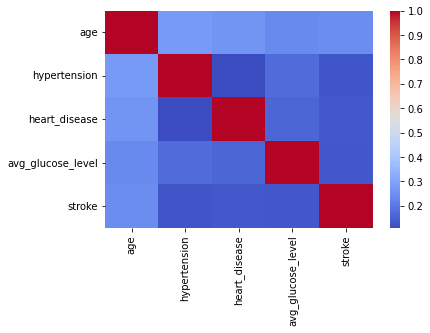

In [13]:
sns.heatmap(abs(stroke_df.corr()), cmap="coolwarm")

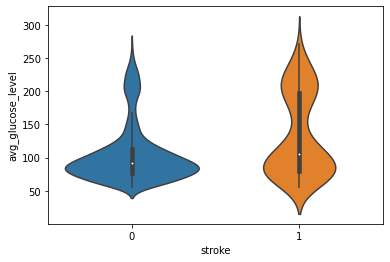

In [15]:
sns.violinplot(x=stroke_df["stroke"], y=stroke_df["avg_glucose_level"], data=stroke_df)

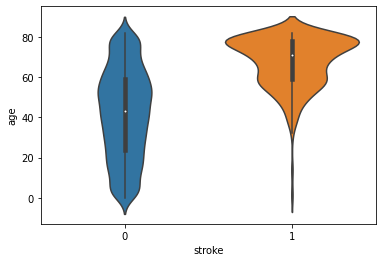

In [16]:
sns.violinplot(x=stroke_df["stroke"], y=stroke_df["age"], data=stroke_df)

### Data analysis

In [20]:
stroke_df.drop(stroke_df[stroke_df["smoking_status"] == "Unknown"].index, inplace=True)  # Observations decreased from 5110 to 3566
stroke_df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

In [21]:
stroke_df.drop(stroke_df[stroke_df["gender"] == "Other"].index, inplace=True)  # Observations decreased from 3566 to 3565
stroke_df['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [22]:
print(stroke_df.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [63]:
stroke_df = stroke_df.fillna(np.mean(stroke_df['bmi']))
print(stroke_df.isnull().sum())

TypeError: ignored

In [27]:
df = pd.get_dummies(stroke_df, columns=['work_type', 'smoking_status'], prefix=['work', 'smoke'])
df.head()

gender   age  hypertension  heart_disease ever_married Residence_type  \
0    Male  67.0             0              1          Yes          Urban   
1  Female  61.0             0              0          Yes          Rural   
2    Male  80.0             0              1          Yes          Rural   
3  Female  49.0             0              0          Yes          Urban   
4  Female  79.0             1              0          Yes          Rural   

   avg_glucose_level   bmi  stroke  work_Govt_job  work_Never_worked  \
0             228.69  36.6       1              0                  0   
1             202.21   N/A       1              0                  0   
2             105.92  32.5       1              0                  0   
3             171.23  34.4       1              0                  0   
4             174.12    24       1              0                  0   

   work_Private  work_Self-employed  work_children  smoke_formerly smoked  \
0             1                   0              0                      1   
1             0                   1              0                      0   
2             1                   0              0                      0   
3             1                   0              0                      0   
4             0                   1              0                      0   

   smoke_never smoked  smoke_smokes  
0                   0             0  
1                   1             0  
2                   1             0  
3                   0             1  
4                   1             0

In [28]:
df['ever_married'] = np.where(df['ever_married'] == 'Yes', 1, 0)
df['gender'] = np.where(df['gender'] == 'Male', 1, 0)
df['Residence_type'] = np.where(df['Residence_type'] == 'Urban', 1, 0)
df.head()

gender   age  hypertension  heart_disease  ever_married  Residence_type  \
0       1  67.0             0              1             1               1   
1       0  61.0             0              0             1               0   
2       1  80.0             0              1             1               0   
3       0  49.0             0              0             1               1   
4       0  79.0             1              0             1               0   

   avg_glucose_level   bmi  stroke  work_Govt_job  work_Never_worked  \
0             228.69  36.6       1              0                  0   
1             202.21   N/A       1              0                  0   
2             105.92  32.5       1              0                  0   
3             171.23  34.4       1              0                  0   
4             174.12    24       1              0                  0   

   work_Private  work_Self-employed  work_children  smoke_formerly smoked  \
0             1                   0              0                      1   
1             0                   1              0                      0   
2             1                   0              0                      0   
3             1                   0              0                      0   
4             0                   1              0                      0   

   smoke_never smoked  smoke_smokes  
0                   0             0  
1                   1             0  
2                   1             0  
3                   0             1  
4                   1             0

### Machine learning modelling

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import SMOTE

In [30]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(est, X_train, y_train) :
    train_sizes, train_scores, test_scores = learning_curve(estimator=est, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8,10))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
    plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
    plt.grid(b='on')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6, 1.0])
    plt.title('%s'%est) 
    plt.show()

In [32]:
def plot_roc_curve(est,X_test,y_test) :
    probas = est.predict_proba(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,probas[:, 1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')        
    plt.plot([0,0,1],[0,1,1],'g:')     # plus mauvaise courbe
    plt.xlim([-0.05,1.2])
    plt.ylim([-0.05,1.2])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show

In [62]:
X = df.drop(['stroke'],axis=1)
y = df['stroke']
sm = SMOTE(random_state=2)
X, y = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


ValueError: ignored

In [34]:
# Logistic Regression
logit = LogisticRegression()
logit.fit(X_train, y_train)
logit.pred = logit.predict(X_test)
logit_accuracy = accuracy_score(logit.pred, y_test)
print('Accuracy:', logit_accuracy)
precision = precision_score(y_test, logit.pred)
print('Precision:', precision)
print(classification_report(y_test, logit.pred))

NameError: ignored

In [54]:
plot_learning_curve(logit, X_train, y_train)

NameError: ignored

In [55]:
# Random Forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
RF.pred = RF.predict(X_test)
RF_accuracy = accuracy_score(RF.pred, y_test)
print('Accuracy:', RF_accuracy)
precision = precision_score(y_test, RF.pred)
print('Precision:', precision)
print(classification_report(y_test, RF.pred))

NameError: ignored

In [56]:
plot_learning_curve(RF, X_train, y_train)

NameError: ignored

In [57]:
# ExtraTrees
ET = ExtraTreesClassifier()
ET.fit(X_train, y_train)
ET.pred = ET.predict(X_test)
ET_accuracy = accuracy_score(ET.pred, y_test)
print('Accuracy:', ET_accuracy)
precision = precision_score(y_test, ET.pred)
print('Precision:', precision)
print(classification_report(y_test, ET.pred))

NameError: ignored

In [58]:
plot_learning_curve(ET, X_train, y_train)

NameError: ignored

In [59]:
# Gradient Boosting
GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)
GB.pred = GB.predict(X_test)
GB_accuracy = accuracy_score(GB.pred, y_test)
print('Accuracy:', GB_accuracy)
precision = precision_score(y_test, GB.pred)
print('Precision:', precision)
print(classification_report(y_test, GB.pred))

NameError: ignored

In [60]:
plot_learning_curve(GB, X_train, y_train)

NameError: ignored